In [32]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
from scipy import integrate

In [33]:
import master, constants

# Time Series Data

In [3]:
# DATA SOURCES
global_deaths_url = constants.GLOBAL['global_deaths_url']
global_confirmed_url = constants.GLOBAL['global_confirmed_url']
global_recovered_url = constants.GLOBAL['global_recovered_url']

In [29]:
# CREATING TRANSFORMER INSTANCE
transformer = master.DataTransformer()

In [21]:
# LOADING DATA
dfd = transformer.load_data(global_deaths_url)
dfc = transformer.load_data(global_confirmed_url)
dfr = transformer.load_data(global_recovered_url)

In [22]:
dfc.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1099,1122,1137,1143,1164,1184,1197,1212,1232,1246
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,764,764,764,765,844,851,852,852,852,852
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,81,84,86,86,86,86,86,86,88,91


# Lat/Long Data

In [23]:
# LAT / LONG DATA
lat_long_df = transformer.prepare_latlong_data(dfd)

# Data Transformation

In [8]:
# COLUMNS TO SELECT
cols = [col for col in dfd.columns if col not in ["Lat","Long","Province/State"]]
date_cols = [col for col in dfd.columns if col not in ["Lat","Long","Province/State", "Country/Region"]]

In [24]:
# master_data = transformer.prepare_master_data([dfd, dfc, dfr], cols, date_cols, region_col = "Country/Region", for_world = True, for_model = False, is_sir_model = False)   # contains time series data for all the countries
# master_data_var = transformer.prepare_master_data([dfd, dfc, dfr], cols, date_cols, region_col = "Country/Region", for_world = True, for_model = True, is_sir_model = False)   # contains time series data for all the countries
master_data_sir = transformer.prepare_master_data([dfd, dfc, dfr], cols, date_cols, region_col = "Country/Region", for_world = True, for_model = True, is_sir_model = True)   # contains time series data for all the countries

for_model :True


In [25]:
master_data_sir.head()

,deaths,confirmed,recovered,active,region
Date,,,,,
2020-02-25,0,1,0,1,Afghanistan
2020-02-26,0,1,0,1,Afghanistan
2020-02-27,0,1,0,1,Afghanistan
2020-02-28,0,1,0,1,Afghanistan
2020-02-29,0,1,0,1,Afghanistan


# Fitting SIR Model using class

In [261]:
# -*- coding: utf-8 -*-
"""
Created on Fri May 15 20:39:25 2020

@author: gdanish
"""

import numpy as np
import pandas as pd
import datetime
import constants
import requests

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from scipy import integrate, optimize
from sklearn.metrics import mean_squared_log_error
    
class DataLoader():
    
    # def __init__(self, url):
    #     self.url = url
        
    def load_data(self, url):
        return pd.read_csv(url)
    
    def prepare_latlong_data(self, df):
        
        # LAT / LONG DATA
        lat_long_df = df[["Country/Region","Lat","Long"]]
        lat_long_df.columns = ['country', 'Lat', 'Long']
        lat_long_df = lat_long_df.groupby(["country"]).agg({"Lat":"first","Long":"first"})
        # lat_long_df = lat_long_df.groupby(["Country/Region"]).agg({"Lat":"first","Long":"first"})
        
        # COLONIAL/PROVINCIAL COUNTRIES
        coord_list = constants.COORDS["coord_list"]
        
        # SETTING ONE SINGLE LAT/LONG FOR THESE COUNTRIES
        coord_df = pd.DataFrame(coord_list).set_index('country')
        coord_df_join =  lat_long_df.join(coord_df, rsuffix = 'c')
        # print(coord_df_join.head())
        
        coord_df_join['Latm'] = np.where(coord_df_join['Latc'].isnull(),coord_df_join['Lat'],coord_df_join['Latc'])
        coord_df_join['Longm'] = np.where(coord_df_join['Longc'].isnull(),coord_df_join['Long'],coord_df_join['Longc'])
        # print(coord_df_join.head())
        
        coord_df_join = coord_df_join[['Latm','Longm']]
        coord_df_join.columns = ['Lat','Long']
        
        return coord_df_join

    def is_cumulative_increasing(self, series):
        s = series.copy()
        # print(s)
        bad_idx_1 = [i for i in range(len(s)-1) if (s[i] > s[i+1]) & (s[i] > s[i-1])]
        bad_idx_2 = [i+1 for i in range(len(s)-2) if (s[i+1] < s[i]) & (s[i+1] < s[i+2])]
    
        # print(bad_idx_1, bad_idx_2)
        bad_idx_arr = bad_idx_1 + bad_idx_2
        
        if len(bad_idx_arr):    
            return False, bad_idx_arr
        else:
            return True, bad_idx_arr

    def check_source_data(self, series):
        s = series.copy()
        is_inc, bad_idx = self.is_cumulative_increasing(s)
        if not is_inc:
            for idx in bad_idx:
                update_val = s[idx-1]
    #             print(f"idx:{idx}, current val:{s[idx]}, update_val:{update_val}")
                s[idx] = update_val
    #             print(f"idx:{idx}, current val:{s[idx]}")
        return s
    
    def prepare_timeseries(self, dfx, cols, region, region_col):
        # TS DATA FOR WORLD
        if region.lower() == "world":
            ser = dfx[cols].agg(sum) # aggregating for the world
            ser = self.check_source_data(ser) # checking the source data is cumulative increasing or not
            
        # TS DATA FOR COUNTRY
        else:
            ser = dfx[cols].groupby([region_col]).agg(sum) # some countries have state-wise data, so aggreagting
            ser = ser.loc[region]
            ser = self.check_source_data(ser) # checking the source data is cumulative increasing or not
            # print(ser)
        # print(ser[:2])
        ser.index = pd.to_datetime(ser.index)
        if len(ser) == 0:
            print(f"ERROR: CHECK REGION - {region}")
        # print(ser[:2])
        return ser
        
    def find_infection_start_date(self, s, region):
        # if region.lower() == 'an':
        #     print(s[:2])
        #     print(s[s > 0][:2])
        s_pos = s[s > 0]
        isd = pd.to_datetime(s.index[-1]) if len(s_pos) == 0 else pd.to_datetime(s_pos.index[0])
        
        # print(f"region : {region} len:{len(s_pos)} isd: {isd}")
        return isd
        
    def concatenate_series(self, list_series, colnames):
        df = pd.concat(list_series, axis = 1).reset_index()
        df.columns = colnames
        return df
    
    def get_daily_data(self, series, infection_start_date, for_model):
        
        # print(infection_start_date)
        
        # model is trained on data starting from first infection
        if for_model:
            series = series.loc[series.index > infection_start_date]
            if len(series) == 0: # no cases in this region so far,
                return series
        
        series_diff = series.diff(periods = 1)
        # print(f"series 0 : {len(series)} , diff 0 : {len(series_diff)}")
        series_diff[0] = series[0] # substituting for NA
        # print(lseries)
        # print(series_diff)
        # print(series[:3])
        # print(series_diff[:5])
        
        return series_diff
        
    def calculate_growth_rate(self, df):
        
        df_world = df.copy()
        df_world = df_world.set_index('Date').astype(float)
        # if region.lower() == "mh":
        #     print(df_world.head())
        #     print(df_world.info())
        df_world["active_incr_rate"] = np.round(100 * df_world["active_incr"] / (df_world["active"] - df_world["active_incr"]), 2)
        df_world["deaths_incr_rate"] = np.round(100 * df_world["deaths_incr"] / (df_world["deaths"] - df_world["deaths_incr"]), 2)
        df_world["confirmed_incr_rate"] = np.round(100 * df_world["confirmed_incr"] / (df_world["confirmed"] - df_world["confirmed_incr"]), 2)
        df_world["recovered_incr_rate"] = np.round(100 * df_world["recovered_incr"] / (df_world["recovered"] - df_world["recovered_incr"]), 2)
        
        # df_world["active_incr_frac"] = np.round(100 * df_world["active_incr"] / (df_world["confirmed_incr"]), 2)
        # df_world["deaths_incr_frac"] = np.round(100 * df_world["deaths_incr"] / (df_world["confirmed_incr"]), 2)
        # df_world["recovery_incr_frac"] = np.round(100 * df_world["recovered_incr"] / (df_world["confirmed_incr"]), 2)
        
        df_world["active_frac"] = np.round(100 * df_world["active"] / (df_world["confirmed"]), 2)
        df_world["deaths_frac"] = np.round(100 * df_world["deaths"] / (df_world["confirmed"]), 2)
        df_world["recovery_frac"] = np.round(100 * df_world["recovered"] / (df_world["confirmed"]), 2)
        
        # df_world["transmission_rate"] = np.round(df_world["active_incr"] / df_world["active"], 2)
        # df_world["case_fatality_rate"] = np.round(df_world["deaths_incr"] / df_world["active"], 2)
        # df_world["removal_rate"] = np.round((df_world["recovered_incr"] + df_world["deaths_incr"])/ df_world["active"], 2)
        
        # df_world["incubation_period"] = np.round(1.0 / df_world["transmission_rate"], 2)
        # df_world["infection_period"] = np.round(1.0 / df_world["removal_rate"], 2)
        df_world["reproduction_number"] = np.round((1 + df_world["active_incr"] / df_world["recovered_incr"]), 2)
        
        # df_world['incubation_period'] = df_world['incubation_period'].replace([np.inf, -np.inf], 1)
        # df_world['infection_period'] = df_world['infection_period'].replace([np.inf, -np.inf], 1)
        df_world['reproduction_number'] = df_world['reproduction_number'].replace([np.inf, -np.inf], 1)
        
        df_world = df_world.replace([np.inf, -np.inf], 100)
        df_world.fillna(0, inplace = True)
        
        df_world["active_incr_rate"] = df_world["active_incr_rate"].astype(str) + '%'
        df_world["deaths_incr_rate"] = df_world["deaths_incr_rate"].astype(str) + '%'
        df_world["confirmed_incr_rate"] = df_world["confirmed_incr_rate"].astype(str) + '%'
        df_world["recovered_incr_rate"] = df_world["recovered_incr_rate"].astype(str) + '%'
        
        # df_world["active_incr_frac"] = df_world["active_incr_frac"].astype(str) + '%'
        # df_world["deaths_incr_frac"] = df_world["deaths_incr_frac"].astype(str) + '%'
        # df_world["recovery_incr_frac"] = df_world["recovery_incr_frac"].astype(str) + '%'
        
        df_world["active_frac"] = df_world["active_frac"].astype(str) + '%'
        df_world["deaths_frac"] = df_world["deaths_frac"].astype(str) + '%'
        df_world["recovery_frac"] = df_world["recovery_frac"].astype(str) + '%'
        
        # df_world.reset_index(inplace = True)
        return df_world
    
    def get_region_ts_dict(self, final_forecast, i):
        dct = {
            'Date': final_forecast['Date'].astype(str).loc[i][:10],
            'active': int(final_forecast.loc[i,'active']),
            'deaths': int(final_forecast.loc[i,'deaths']),
            'confirmed': int(final_forecast.loc[i,'confirmed']),
            'recovered': int(final_forecast.loc[i,'recovered']),
            'active_incr': int(final_forecast.loc[i,'active_incr']),
            'deaths_incr': int(final_forecast.loc[i,'deaths_incr']),
            'confirmed_incr': int(final_forecast.loc[i,'confirmed_incr']),
            'recovered_incr': int(final_forecast.loc[i,'recovered_incr']),
            'active_incr_rate': final_forecast.loc[i,'active_incr_rate'],
            'deaths_incr_rate': final_forecast.loc[i,'deaths_incr_rate'],
            'confirmed_incr_rate': final_forecast.loc[i,'confirmed_incr_rate'],
            'recovered_incr_rate': final_forecast.loc[i,'recovered_incr_rate'],
            # 'active_incr_frac': final_forecast.loc[i,'active_incr_frac'],
            # 'deaths_incr_frac': final_forecast.loc[i,'deaths_incr_frac'],
            # 'recovery_incr_frac': final_forecast.loc[i,'recovery_incr_frac'],
            'active_frac': final_forecast.loc[i,'active_frac'],
            'deaths_frac': final_forecast.loc[i,'deaths_frac'],
            'recovery_frac': final_forecast.loc[i,'recovery_frac'],
            # 'transmission_rate': final_forecast.loc[i,'transmission_rate'],
            # 'case_fatality_rate': final_forecast.loc[i,'case_fatality_rate'],
            # 'removal_rate': final_forecast.loc[i,'removal_rate'],
            # 'incubation_period': final_forecast.loc[i,'incubation_period'],
            # 'infection_period': final_forecast.loc[i,'infection_period'],
            'reproduction_number': final_forecast.loc[i,'reproduction_number']
        }
        return dct
    
    def get_countrywise_stats_dict(self, df_country, i):
        country_dict = {
            'Country': df_country.loc[i,'region'],
            'Lat': float(df_country.loc[i,'Lat']),
            'Long': float(df_country.loc[i,'Long']),
            'deaths': int(df_country.loc[i,'deaths']),
            'confirmed': int(df_country.loc[i,'confirmed']),
            'recovered': int(df_country.loc[i,'recovered']),
            'active': int(df_country.loc[i,'active']),
            'deaths_incr': int(df_country.loc[i,'deaths_incr']),
            'confirmed_incr': int(df_country.loc[i,'confirmed_incr']),
            'recovered_incr': int(df_country.loc[i,'recovered_incr']),
            'active_incr': int(df_country.loc[i,'active_incr']),
            'deaths_incr_rate': df_country.loc[i,'deaths_incr_rate'],
            'confirmed_incr_rate': df_country.loc[i,'confirmed_incr_rate'],
            'recovered_incr_rate': df_country.loc[i,'recovered_incr_rate'],
            # 'active_incr_frac': df_country.loc[i,'active_incr_frac'],
            # 'deaths_incr_frac': df_country.loc[i,'deaths_incr_frac'],
            # 'recovery_incr_frac': df_country.loc[i,'recovery_incr_frac'],
            'active_frac': df_country.loc[i,'active_frac'],
            'deaths_frac': df_country.loc[i,'deaths_frac'],
            'recovery_frac': df_country.loc[i,'recovery_frac'],
            # 'transmission_rate': df_country.loc[i,'transmission_rate'],
            # 'case_fatality_rate': df_country.loc[i,'case_fatality_rate'],
            # 'removal_rate': df_country.loc[i,'removal_rate'],
            # 'incubation_period': df_country.loc[i,'incubation_period'],
            # 'infection_period': df_country.loc[i,'infection_period'],
            'reproduction_number': df_country.loc[i,'reproduction_number']
        }
        return country_dict
    
    def get_statewise_stats_dict(self, df_states_overall, i):
        state_dict = {
            # 
            'State': df_states_overall.loc[i,'state'],
            'State Code': df_states_overall.loc[i,'region'].upper(),
            'Lat': float(df_states_overall.loc[i,'latitude']),
            'Long': float(df_states_overall.loc[i,'longitude']),
            'deaths': int(df_states_overall.loc[i,'deaths']),
            'confirmed': int(df_states_overall.loc[i,'confirmed']),
            'recovered': int(df_states_overall.loc[i,'recovered']),
            'deaths_incr': int(df_states_overall.loc[i,'deaths_incr']),
            'confirmed_incr': int(df_states_overall.loc[i,'confirmed_incr']),
            'recovered_incr': int(df_states_overall.loc[i,'recovered_incr']),
            'deaths_incr_rate': df_states_overall.loc[i,'deaths_incr_rate'],
            'confirmed_incr_rate': df_states_overall.loc[i,'confirmed_incr_rate'],
            'recovered_incr_rate': df_states_overall.loc[i,'recovered_incr_rate'],
            # 'active_incr_frac': df_states_overall.loc[i,'active_incr_frac'],
            # 'deaths_incr_frac': df_states_overall.loc[i,'deaths_incr_frac'],
            # 'recovery_incr_frac': df_states_overall.loc[i,'recovery_incr_frac'],
            'active_frac': df_states_overall.loc[i,'active_frac'],
            'deaths_frac': df_states_overall.loc[i,'deaths_frac'],
            'recovery_frac': df_states_overall.loc[i,'recovery_frac'],
            # 'transmission_rate': df_states_overall.loc[i,'transmission_rate'],
            # 'case_fatality_rate': df_states_overall.loc[i,'case_fatality_rate'],
            # 'removal_rate': df_states_overall.loc[i,'removal_rate'],
            # 'incubation_period': df_states_overall.loc[i,'incubation_period'],
            # 'infection_period': df_states_overall.loc[i,'infection_period'],
            'reproduction_number': df_states_overall.loc[i,'reproduction_number']
        }
        return state_dict
    
    def get_districtwise_stats_dict(self, dct):
        
        dist_dict = {}
        dist_dict['district'] = dct['district']
        dist_dict['confirmed'] = dct['confirmed']
        dist_dict['deaths'] = dct['deceased']
        dist_dict['recovered'] = dct['recovered']
        dist_dict['active'] = dist_dict['confirmed'] - dist_dict['deaths'] - dist_dict['recovered']
        
        dist_dict['deaths_frac'] = np.round(100 * dist_dict['deaths'] / dist_dict['confirmed'])
        dist_dict['recovered_frac'] = np.round(100 * dist_dict['recovered'] / dist_dict['confirmed'])
        dist_dict['active_frac'] = np.round(100 * dist_dict['active'] / dist_dict['confirmed'])
        
        dist_dict['confirmed_incr'] = dct['delta']['confirmed']
        dist_dict['recovered_incr'] = dct['delta']['recovered']
        dist_dict['deaths_incr'] = dct['delta']['deceased']
        dist_dict['active_incr'] = dist_dict['confirmed_incr'] - dist_dict['deaths_incr'] - dist_dict['recovered_incr']
        
        dist_dict['confirmed_incr_rate'] = 0.0 if dist_dict['confirmed'] - dist_dict['confirmed_incr'] == 0 else np.round(100 * dist_dict['confirmed_incr'] / (dist_dict['confirmed'] - dist_dict['confirmed_incr']), 2)
        dist_dict['recovered_incr_rate'] = 0.0 if dist_dict['recovered'] - dist_dict['recovered_incr'] == 0 else np.round(100 * dist_dict['recovered_incr'] / (dist_dict['recovered'] - dist_dict['recovered_incr']), 2)
        dist_dict['deaths_incr_rate'] = 0.0 if dist_dict['deaths'] - dist_dict['deaths_incr'] == 0 else np.round(100 * dist_dict['deaths_incr'] / (dist_dict['deaths'] - dist_dict['deaths_incr']), 2)
        dist_dict['active_incr_rate'] = 0.0 if dist_dict['active'] - dist_dict['active_incr'] == 0 else np.round(100 * dist_dict['active_incr'] / (dist_dict['active'] - dist_dict['active_incr']), 2)
        
        # dist_dict["transmission_rate_daily"] = 0.0 if dist_dict['active'] - dist_dict['active_incr'] == 0 else np.round(100 * dist_dict["active_incr"] / (dist_dict["active"] - dist_dict["active_incr"]), 2)
        # dist_dict["case_fatality_rate_daily"] = 0.0 if dist_dict['confirmed_incr'] == 0 else np.round(100 * dist_dict["deaths_incr"] / (dist_dict["confirmed_incr"]), 2)
        # dist_dict["recovery_rate_daily"] = 0.0 if dist_dict['confirmed_incr'] == 0 else np.round(100 * dist_dict["recovered_incr"] / (dist_dict["confirmed_incr"]), 2)
        
        # dist_dict["reproduction_number"] = 0.0 if dist_dict['recovered_incr'] == 0 else np.round((1 + dist_dict["active_incr"] / dist_dict["recovered_incr"]), 2)
        # dist_dict["case_fatality_rate_cum"] = 0.0 if dist_dict['confirmed'] == 0 else np.round(100 * dist_dict["deaths"] / (dist_dict["confirmed"]), 2)
        # dist_dict["recovery_rate_cum"] = 0.0 if dist_dict['confirmed'] == 0 else np.round(100 * dist_dict["recovered"] / (dist_dict["confirmed"]), 2)
        
        dist_dict['confirmed_incr_rate'] = str(dist_dict['confirmed_incr_rate']) + '%'
        dist_dict['recovered_incr_rate'] = str(dist_dict['recovered_incr_rate']) + '%'
        dist_dict['deaths_incr_rate'] = str(dist_dict['deaths_incr_rate']) + '%'
        dist_dict['active_incr_rate'] = str(dist_dict['active_incr_rate']) + '%'
        
        dist_dict['recovered_frac'] = str(dist_dict['recovered_frac']) + '%'
        dist_dict['deaths_frac'] = str(dist_dict['deaths_frac']) + '%'
        dist_dict['active_frac'] = str(dist_dict['active_frac']) + '%'
        # dist_dict['transmission_rate_daily'] = str(dist_dict['transmission_rate_daily']) + '%'
        # dist_dict['case_fatality_rate_daily'] = str(dist_dict['case_fatality_rate_daily']) + '%'
        # dist_dict['recovery_rate_daily'] = str(dist_dict['recovery_rate_daily']) + '%'
        # dist_dict['case_fatality_rate_cum'] = str(dist_dict['case_fatality_rate_cum']) + '%'
        # dist_dict['recovery_rate_cum'] = str(dist_dict['recovery_rate_cum']) + '%'
        
        return dist_dict
    
class DataTransformer(DataLoader):
            
    def prepare_region_ts_dataframe(self, list_df, cols, region, region_col, for_model, is_sir_model):
        
        region_case_series_list = [self.prepare_timeseries(dfx, cols, region, region_col) for dfx in list_df]
        # print(len(region_case_series_list))
        # print(region_case_series_list[0])
        region_active_case_series = region_case_series_list[1] - region_case_series_list[0] - region_case_series_list[2] # active = confirmed - recovered - deaths
        
        region_case_series_list.append(region_active_case_series)
        # print(len(region_case_series_list))
        
        infection_start_date = self.find_infection_start_date(region_case_series_list[1], region)
        # infection_start_date = pd.to_datetime(infection_start_str)
        
        region_case_series_diff_list = [self.get_daily_data(ser, infection_start_date, for_model) for ser in region_case_series_list ]
        
        # print(len(region_case_series_diff_list))
        # print(infection_start_date)
        
        if for_model: 
            # print("INSIDE FOR MODEL")
            model_df_cols =  ["Date","deaths", "confirmed", "recovered", "active"]
            
            # DATA FOR SIR MODEL / VAR MODEL
            df = self.concatenate_series(region_case_series_list, model_df_cols) if is_sir_model else self.concatenate_series(region_case_series_diff_list, model_df_cols)
            df["Date"] = pd.to_datetime(df["Date"])
            
            # TAKING DATA FROM 1st CONFIRMED CASE
            df = df[df.Date > infection_start_date]
            df.set_index('Date', inplace = True)
        else:
            # print(f"INSIDE FOR DATA - {region}")
            comb_lists = region_case_series_list + region_case_series_diff_list
            comb_cols = ["Date","deaths", "confirmed", "recovered","active","deaths_incr","confirmed_incr","recovered_incr","active_incr"]
            df = self.concatenate_series(comb_lists, comb_cols)
            # print(df.head())
        
            # DAILY GROWTH RATE
            df = self.calculate_growth_rate(df)
    
        df['region'] = region
        return df
    
    def prepare_master_data(self, list_df, cols, date_cols, region_col, for_world, for_model, is_sir_model):
        
        # list of all countries
        df = list_df[0]
        regions = df[region_col].unique().tolist()
        if for_world:
            regions.append('World')
        # print(countries)
        
        print(f"for_model :{for_model}")
        # LIST OF DATAFRAMES FOR EACH REGION
        master_list_regions_df = [self.prepare_region_ts_dataframe(list_df, date_cols, region, region_col, for_model, is_sir_model) if region.lower() == "world" 
                           else self.prepare_region_ts_dataframe(list_df, cols, region, region_col, for_model, is_sir_model)  for region in regions]
        
        # CONCATENATING TO ONE SINGLE DATAFRAME
        master_df = pd.concat(master_list_regions_df, axis = 0)
        
        return master_df
            
class DataTransformerIndia(DataTransformer):
    
    def __init__(self, url1, url2):
        self.india_district_url = url1
        self.india_states_daily_url = url2
        
    def load_district_data(self):
        dict_dist = requests.get(self.india_district_url).json()
        df_dist = pd.DataFrame(dict_dist)
        df_dist['statecode'] = df_dist['statecode'].str.lower()
        df_dist['state'] = df_dist['state'].str.lower()
        return df_dist
    
    def load_states_data(self):
        dict_states = requests.get(self.india_states_daily_url).json()
        df_states = pd.DataFrame(dict_states['states_daily'])
        # df_states['date'] = pd.to_datetime(df_states['date'])
        
        # STATES DATA - OVERALL
        int_cols = [col for col in df_states.columns if col not in ['date','status']]
        # df_states_drop = df_states.drop(['date','status'],axis = 1)
        # df_states_drop = df_states_drop.replace('',0).astype(int)
        
        df_states[int_cols] = df_states[int_cols].replace('',0).astype(int)
        
        # df_states_status = df_states.status
        # df_states_comb = pd.concat([df_states_drop,df_states_status], axis = 1)  # Appending status col
        
        return df_states
    
    def load_data(self,df_states, status):
        dfsx = df_states[df_states.status == status]
        dfsx_w0 = dfsx.drop(['status','date'], axis = 1).cumsum()
        dfsx_dt = dfsx['date']
        
        dfsx_comb = pd.concat([dfsx_dt, dfsx_w0], axis = 1)
        dfsx_comb = dfsx_comb.set_index('date').T
        cols = dfsx_comb.columns.tolist()
        dfsx_comb.reset_index(inplace =True)
        dfsx_comb.columns = ['state_code'] + cols
        return dfsx_comb
    
    def load_state_coord_data(self):
        
        # state_code_df = pd.DataFrame(state_code_dict).sort_values('state_code')
        state_code_df = pd.read_csv("state_coords.csv")
        state_code_df['region'] = state_code_df['region'].str.lower()
        state_code_df.set_index('region', inplace = True)
        return state_code_df
    
    def get_statecode_latlong(self, state_code_df, state_name):
        
        # FILTERING FOR THE GIVEN STATE - BY DEFAULT GIVING TOTAL
        state_code_df_mod = state_code_df.copy()
        state_code_df_filt = state_code_df_mod[state_code_df_mod.state.str.lower() == state_name]
        
        state_lat = float(state_code_df_filt.latitude.values[0])
        state_long = float(state_code_df_filt.longitude.values[0])
        state_code = "tt" if state_name == "total" else state_code_df_filt.index[0]
        return state_code, state_lat, state_long

class VectorAutoRegression(DataLoader):
    
    def __init__(self, df, forecast_days):
        
        self.train = df
        self.forecast_days = forecast_days
        self.test_days = 0
        
        # START AND END DATES OF FORECASTING
        self.start_date = self.train.index[-1] + datetime.timedelta(1)
        self.end_date = self.start_date + datetime.timedelta(self.test_days+self.forecast_days-1)      # forecasting for test data + num_days in future
        
        # LOG TRANSFORMATION
        self.train_log = np.log1p(self.train)
        
        # MAKING STATIONARY BY DIFFERENCING
        self.train_diff1 = self.train_log.diff(1).dropna()
        self.train_diff2 = self.train_diff1.diff(1).dropna()
        
    def fit(self):
        
        # STATIONARITY CHECK
        # self.adfuller_test(self.train_diff2.deaths)   
        # self.adfuller_test(self.train_diff2.confirmed)
        # self.adfuller_test(self.train_diff2.recovered)
        
        # MODELING
        model = VAR(self.train_diff2)  # VAR model
        
        # SELECTING ORDER p FOR VAR MODEL
        # x = model.select_order(maxlags=12)
        # x.summary()
        
        # FITTING THE MODEL
        res = model.fit(4)                                 # ORDER = 4 FOR MINIMUM AIC
        return res
    
    def predict(self, res):
        
        # INITIAL INPUT FOR FORECAST
        lag_order = res.k_ar                               # 4 as shosen above
        forecast_input = self.train_diff2.values[-lag_order:]   # Taking last 4 training data as initial input for forecasting
        
        # FORECASTING
        num_days_forecast = self.test_days+self.forecast_days                    # forecasting for test data + num_days in future
        pred = res.forecast(forecast_input, num_days_forecast)  # numpy array of forecast values
        idx = pd.date_range(start=self.start_date, end=self.end_date) # date range for forecast data
        pred_df = pd.DataFrame(pred, index=idx, columns=self.train_diff2.columns + '_2d') # converintg to dataframe
        
        # INVERSE TRANSFORMATION
        pred_df_inv1 = self.invert_transformation(pred_df,self.train_log, self.train_diff1, self.train_diff2, second_diff=True, third_diff=False)      # inverting 2nd diff to 1st diff
        pred_df_inv = self.invert_transformation(pred_df_inv1,self.train_log, self.train_diff1, self.train_diff2, second_diff=False, third_diff=False) # inverting 1st diff and taking inverse log tr
        
        # SELECTING REQUIRED COLUMNS
        df_forecast = pred_df_inv.iloc[:,-3:]
        df_forecast.columns = self.train_diff2.columns
        
        # EVALUATING PREDICTIONS
        # test_f = test.join(df_forecast, rsuffix='_f')
        # mape(test_f.deaths_f, test_f.deaths)
        # mape(test_f.confirmed_f, test_f.confirmed)
        # mape(test_f.recovered_f, test_f.recovered)
        
        # COMBINING TRAIN WITH FORECAST DATA
        new_cases_forecast = pd.concat([self.train, df_forecast], axis = 0)
        new_cases_forecast['active'] = new_cases_forecast['confirmed'] - new_cases_forecast['deaths']- new_cases_forecast['recovered']
        total_cases_forecast = new_cases_forecast.cumsum()
        
        # COMBINING 
        final_forecast = pd.concat([total_cases_forecast,new_cases_forecast], axis = 1).reset_index()
        final_forecast.columns = ['Date'] + new_cases_forecast.columns.tolist() + [col + '_incr' for col in new_cases_forecast.columns]
    
        final_forecast['Date'] = final_forecast.Date.astype(str)
        final_forecast = self.calculate_growth_rate(final_forecast)
        return final_forecast
    
    def adfuller_test(self, series):
        """
        Parameters
        ----------
        series : a time series to check stationarity for
        Null Hypothesis H0 : Series is not stationary

        Returns
        -------
        p_value : Probability that null hypothesis is true

        """
        r = adfuller(series, autolag='AIC')
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue']
        return p_value,p_value <= 0.05
    
    def invert_transformation(self, df_forecast, train_log, train_diff1, train_diff2, second_diff, third_diff):
        """
        Revert back the differencing to get the forecast to original scale.
        """
        df_fc = df_forecast.copy()
        columns = train_log.columns
        
        for col in columns:      
            
            # Roll back 3rd Diff
            if third_diff:
                df_fc[str(col)+'_2d'] = train_diff2[col].iloc[-1] + df_fc[str(col)+'_3d'].cumsum()
            
            # Roll back 2nd Diff
            elif second_diff:
                df_fc[str(col)+'_1d'] = train_diff1[col].iloc[-1] + df_fc[str(col)+'_2d'].cumsum()
            
            # Roll back 1st Diff and take inverse log transformation
            else:
                df_fc[str(col)+'_forecast'] = round(np.expm1(train_log[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()))
        
        return df_fc
    
    
class CompartmentalModel(DataLoader):
    
    def __init__(self, df, region, forecast_days, is_states):
        
        self.train = df
        self.region = region
        self.is_states = is_states
        self.forecast_days = forecast_days
        self.test_days = 0
        
        # START AND END DATES OF FORECASTING
        self.inf_start_date = self.train.index[0]
        self.start_date = self.train.index[-1] + datetime.timedelta(1)
        self.end_date = self.start_date + datetime.timedelta(self.test_days+self.forecast_days-1)      # forecasting for test data + num_days in future
        
        # LOG TRANSFORMATION
        # self.train_log = np.log1p(self.train)
        
    def get_population_data(self):
        """
        Population Size for the Selected Country
        """
        if self.is_states:
            N = state_code_df.loc[self.region]['population']
        else:
            dfp = pd.read_csv("population.csv")
            N = dfp.loc[dfp['Country (or dependency)'].str.lower() == self.region, 'Population (2020)'].values[0]
#         return 50000000
        return int(N)

    
    def get_initial_guess_for_hyperparams(self):
        # TUNING PARAMETERS
        beta = 0.001 # transmission_rate
        gamma = 0.001 # removal_rate
        cfr = 0.2 # case_fatality_rate
        initial_guess = (beta, gamma, cfr)
        return initial_guess
    
    def get_sir_model_data(self):
        
        # Population data for the country
        N = self.get_population_data()
        df = self.train
        
        # Filtering TS data for the country
        df = df[df.region.str.lower() == self.region].iloc[:,:3]
        
        # Creating S, I, R series data
        df['removed'] = df['deaths'] + df['recovered']
        df['infected'] = df['confirmed'] - df['removed']
        df['susceptible'] = N - df['infected'] - df['removed']
        
        # Selecting required cols and normalizing
#         dfm = df.iloc[:,3:] / N
        dfm = df.iloc[:,3:]
        return dfm
    
    def get_initial_condition(self, df):
        # Initial Conditions
        y_0 = df.values[0]
        
        return y_0.tolist()
    
    def msle(self,x,y):
        return np.mean((np.log1p(x) - np.log1p(y))**2)

    def fit(self):
        
        sir_df = self.get_sir_model_data()
        print(sir_df.head())
        y_0 = self.get_initial_condition(sir_df)
        print(y_0)
        params_0 = self.get_initial_guess_for_hyperparams()
        print(params_0)
        optimal = optimize.minimize(
            self.loss,
            params_0[:-1],
            args=(sir_df, y_0),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        beta, gamma = optimal.x
        return optimal
        
    def loss(self, params, df, y_0):
        
        size = len(df)
        
        def sir_model(t, y):
            """
            # Model Definition
            """
            # Unpacking variables and parameters
            r, i, s = y
            beta, gamma = params
            
            # Differential Equations of SIR Model
            dsdt = -beta * s * i
            didt = beta * s * i - gamma * i
            drdt = gamma * i
            return [drdt, didt, dsdt]
        
        # Solving Initial Value Problem - Uses Runge-Kutta RK45 Algorithm
        solution = integrate.solve_ivp(sir_model, [0, size], y_0, t_eval=np.arange(0, size, 1), vectorized=True)
        
        # Calculate MSLE Loss
#         l0 = mean_squared_log_error(df.removed, solution.y[0])
#         l1 = mean_squared_log_error(df.infected, solution.y[1])
#         l2 = mean_squared_log_error(df.susceptible, solution.y[2])

        l0 = self.msle(df.removed, solution.y[0])
        l1 = self.msle(df.infected, solution.y[1])
        l2 = self.msle(df.susceptible, solution.y[2])
        
        # Put more emphasis on recovered people
#         alpha = 0.1
#         msle_weighted = alpha * l1 + (1 - alpha) * l2
        msle_weighted = np.mean([l0,l1,l2])
        print(f"MSLE Removed :{l0}, MSLE Infected :{l1}, MSLE Susceptible :{l2}, MSLE Average :{msle_weighted}")
        return msle_weighted
    
    def predict(self, params, df):
        
        # EXTENDING DATES
        idx = pd.date_range(start=self.inf_start_date, end=self.end_date) # date range for forecast data
        
        size = len(idx)
        
        def sir_model(t, y):
            """
            # Model Definition
            """
            # Unpacking variables and parameters
            r, i, s = y
            beta, gamma = params
            
            # Differential Equations of SIR Model
            dsdt = -beta * s * i
            didt = beta * s * i - gamma * i
            drdt = gamma * i
            return [drdt, didt, dsdt]
        
        # Solving Initial Value Problem - Uses Runge-Kutta RK45 Algorithm
        solution = integrate.solve_ivp(sir_model, [0, size], y_0, t_eval=np.arange(0, size, 1), vectorized=True)
        
        # Creating Forecast DF
        forecast_df = pd.DataFrame({"removed_f":solution.y[0],"infected_f":solution.y[1],"susceptible_f":solution.y[2]},index = idx)
        forecast_df = forecast_df.join(df)
        return forecast_df

In [263]:
sir = CompartmentalModel(master_data_sir, "india", 50, False)

In [216]:
N = sir.get_population_data()
df = sir.train

In [217]:
sir_df = sir.get_sir_model_data()

In [218]:
sir.train[sir.train.region.str.lower()=='india'].head()

,deaths,confirmed,recovered,active,region
Date,,,,,
2020-01-31,0,1,0,1,India
2020-02-01,0,1,0,1,India
2020-02-02,0,2,0,2,India
2020-02-03,0,3,0,3,India
2020-02-04,0,3,0,3,India


In [219]:
sir_df.head()

,removed,infected,susceptible
Date,,,
2020-01-31,0,1,49999999
2020-02-01,0,1,49999999
2020-02-02,0,2,49999998
2020-02-03,0,3,49999997
2020-02-04,0,3,49999997


In [220]:
y_0 = sir.get_initial_condition(sir_df)

In [221]:
y_0

[0, 1, 49999999]

In [222]:
params_0 = sir.get_initial_guess_for_hyperparams()

In [223]:
params_0

(0.001, 0.001, 0.2)

In [230]:
np.random.randn(2,3)

array([[ 1.42298201, -0.90399455, -0.01957713],
       [ 0.85028502,  0.22507938, -1.26457474]])

In [227]:
optimal = optimize.minimize(
            sir.loss,
            params_0[:-1],
            args=(sir_df, y_0),
            method='L-BFGS-B',
            bounds=[(0.000001, 0.4), (0.000001, 0.4)],
            options={'verbose':1}
        )

In [196]:
optimal.x

array([1.00000000e-06, 5.92306262e-05])

In [197]:
res = sir.predict(optimal.x, sir_df)

In [199]:
res.tail(100)

,removed_f,infected_f,susceptible_f,removed,infected,susceptible
2020-04-19,821.270083,499178.251214,4.787037e-01,3413.0,14202.0,482385.0
2020-04-20,850.835854,499148.872965,2.911815e-01,3865.0,14674.0,481461.0
2020-04-21,880.399882,499119.423530,1.765882e-01,4620.0,15460.0,479920.0
2020-04-22,909.962165,499089.930419,1.074166e-01,5051.0,16319.0,478630.0
2020-04-23,939.522700,499060.412150,6.514990e-02,5733.0,17344.0,476923.0
...,...,...,...,...,...,...
2020-07-23,3622.215832,496377.784168,-2.531728e-07,NaN,NaN,NaN
2020-07-24,3651.615728,496348.384272,-6.041878e-07,NaN,NaN,NaN
2020-07-25,3681.013883,496318.986117,-4.446193e-07,NaN,NaN,NaN
2020-07-26,3710.410297,496289.589703,1.437752e-07,NaN,NaN,NaN


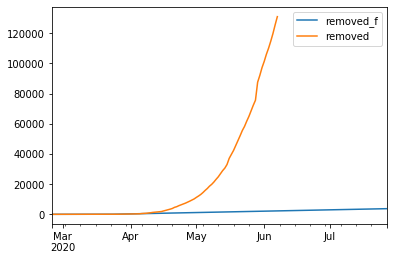

In [200]:
res.iloc[:,[0,3]].plot()

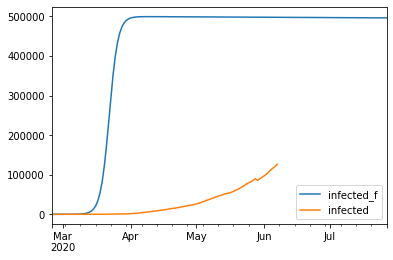

In [201]:
res.iloc[:,[1,4]].plot()

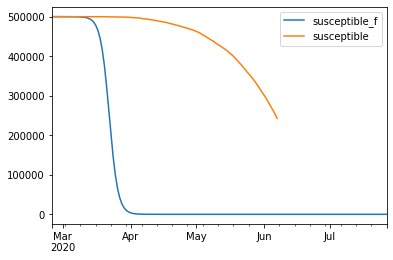

In [202]:
res.iloc[:,[2,5]].plot()

# India States

In [286]:
# INDIA DATA
india_district_url = constants.INDIA['india_district_url']
india_states_daily_url = constants.INDIA['india_states_daily_url']

# CREATING INSTANCE
statesman = master.DataTransformerIndia(india_district_url, india_states_daily_url)

In [287]:
# DISTRICTS AND STATES DATA
df_dist = statesman.load_district_data()
df_states = statesman.load_states_data()
dfsd, dfsc, dfsr = [statesman.load_data(df_states, status) for status in ['Deceased', 'Confirmed', 'Recovered']]

In [288]:
# STATES COORDS DATA
state_code_df = statesman.load_state_coord_data()
# print(state_code_df.head())

# REQUIRED COLUMN NAMES
cols_state = dfsd.columns.tolist()
date_cols_state = [col for col in dfsd.columns if col not in ["state_code"]]

In [289]:
state_code_df.head()

,state,latitude,longitude,population
region,,,,
an,Andaman and Nicobar Islands,11.740087,92.658640,380581.0
ap,Andhra Pradesh,15.912900,79.740000,84580777.0
ar,Arunachal Pradesh,28.210000,94.720000,1383727.0
as,Assam,26.244156,92.537842,31205576.0
br,Bihar,25.090000,85.310000,104099452.0


In [290]:
# FINDING STATES MASTER DATA
# state_master_data = statesman.prepare_master_data([dfsd, dfsc, dfsr], cols_state, date_cols_state, region_col = "state_code", for_world = False, for_model = False, is_sir_model = False)   # contains time series data for all the countries
# state_master_data_var = statesman.prepare_master_data([dfsd, dfsc, dfsr], cols_state, date_cols_state, region_col = "state_code", for_world = False, for_model = True, is_sir_model = False)   # contains time series data for all the countries
state_master_data_sir = statesman.prepare_master_data([dfsd, dfsc, dfsr], cols_state, date_cols_state, region_col = "state_code", for_world = False, for_model = True, is_sir_model = True)   # contains time series data for all the countries

for_model :True


In [291]:
state_master_data_sir

,deaths,confirmed,recovered,active,region
Date,,,,,
2020-03-27,0,6,0,6,an
2020-03-28,0,9,0,9,an
2020-03-29,0,9,0,9,an
2020-03-30,0,10,0,10,an
2020-03-31,0,10,0,10,an
...,...,...,...,...,...
2020-06-04,355,6876,2768,3753,wb
2020-06-05,366,7303,2912,4025,wb
2020-06-06,383,7738,3119,4236,wb


In [292]:
state_master_data_sir.region.nunique()

37

In [285]:
state_master_data_sir[state_master_data_sir.region.str.lower()=='wb']

,deaths,confirmed,recovered,active,region
Date,,,,,
2020-03-18,0,1,0,1,wb
2020-03-19,0,1,0,1,wb
2020-03-20,0,2,0,2,wb
2020-03-21,0,4,0,4,wb
2020-03-22,0,7,0,7,wb
...,...,...,...,...,...
2020-06-04,355,6876,2768,3753,wb
2020-06-05,366,7303,2912,4025,wb
2020-06-06,383,7738,3119,4236,wb


In [264]:
sir_states = CompartmentalModel(state_master_data_sir, "dd", 50, True)

In [265]:
N = sir_states.get_population_data()
df = sir_states.train

In [270]:
df

,deaths,confirmed,recovered,active,region
Date,,,,,
2020-03-27,0,6,0,6,an
2020-03-28,0,9,0,9,an
2020-03-29,0,9,0,9,an
2020-03-30,0,10,0,10,an
2020-03-31,0,10,0,10,an
...,...,...,...,...,...
2020-06-04,355,6876,2768,3753,wb
2020-06-05,366,7303,2912,4025,wb
2020-06-06,383,7738,3119,4236,wb


In [267]:
sir_states_df = sir_states.get_sir_model_data()

In [277]:
df[df.region.str.lower()=='dd']

,deaths,confirmed,recovered,active,region
Date,,,,,


In [219]:
sir_df.head()

,removed,infected,susceptible
Date,,,
2020-01-31,0,1,49999999
2020-02-01,0,1,49999999
2020-02-02,0,2,49999998
2020-02-03,0,3,49999997
2020-02-04,0,3,49999997


In [220]:
y_0 = sir.get_initial_condition(sir_df)

In [221]:
y_0

[0, 1, 49999999]

In [222]:
params_0 = sir.get_initial_guess_for_hyperparams()

In [223]:
params_0

(0.001, 0.001, 0.2)

In [230]:
np.random.randn(2,3)

array([[ 1.42298201, -0.90399455, -0.01957713],
       [ 0.85028502,  0.22507938, -1.26457474]])

In [227]:
optimal = optimize.minimize(
            sir.loss,
            params_0[:-1],
            args=(sir_df, y_0),
            method='L-BFGS-B',
            bounds=[(0.000001, 0.4), (0.000001, 0.4)],
            options={'verbose':1}
        )

In [196]:
optimal.x

array([1.00000000e-06, 5.92306262e-05])

In [197]:
res = sir.predict(optimal.x, sir_df)

In [199]:
res.tail(100)

,removed_f,infected_f,susceptible_f,removed,infected,susceptible
2020-04-19,821.270083,499178.251214,4.787037e-01,3413.0,14202.0,482385.0
2020-04-20,850.835854,499148.872965,2.911815e-01,3865.0,14674.0,481461.0
2020-04-21,880.399882,499119.423530,1.765882e-01,4620.0,15460.0,479920.0
2020-04-22,909.962165,499089.930419,1.074166e-01,5051.0,16319.0,478630.0
2020-04-23,939.522700,499060.412150,6.514990e-02,5733.0,17344.0,476923.0
...,...,...,...,...,...,...
2020-07-23,3622.215832,496377.784168,-2.531728e-07,NaN,NaN,NaN
2020-07-24,3651.615728,496348.384272,-6.041878e-07,NaN,NaN,NaN
2020-07-25,3681.013883,496318.986117,-4.446193e-07,NaN,NaN,NaN
2020-07-26,3710.410297,496289.589703,1.437752e-07,NaN,NaN,NaN


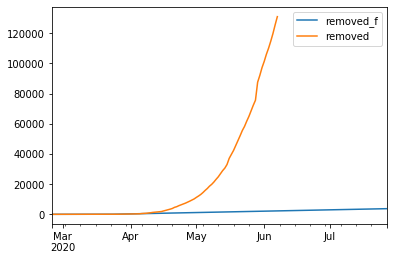

In [200]:
res.iloc[:,[0,3]].plot()

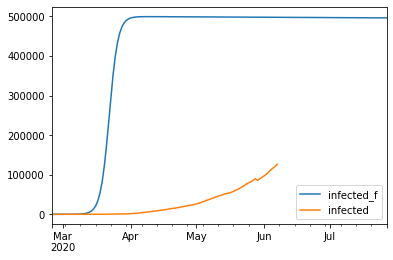

In [201]:
res.iloc[:,[1,4]].plot()

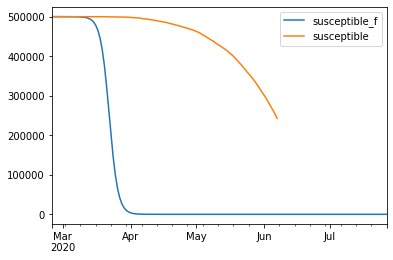

In [202]:
res.iloc[:,[2,5]].plot()

In [141]:
import seaborn as sns

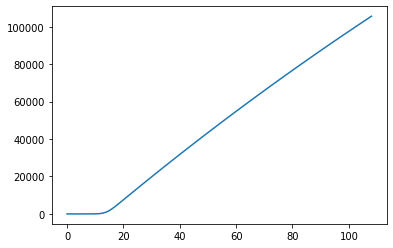

In [142]:
sns.lineplot(x = res.t, y= res.y[0])
sns.lineplot(x = res.t, y = sir_df)

# Population Data

In [11]:
dfp = pd.read_csv("population.csv")

In [12]:
dfp.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1438207241,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1377233523,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,330610570,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,272931713,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,219992900,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


# Initial Condition

In [13]:
country_name = "Iran"

In [14]:
# Population Size for the Selected Country
N = dfp.loc[dfp['Country (or dependency)'] == country_name, 'Population (2020)'].values[0]

In [15]:
N

83771587

In [444]:
# Normalized Data
# master_data_norm = master_data[master_data.country == country_name].drop('country', axis = 1) / N
master_data_norm = master_data[master_data.country == country_name].drop('country', axis = 1)

In [445]:
# Creating S, I, R series data
master_data_norm['removed'] = master_data_norm['deaths'] + master_data_norm['recovered']
master_data_norm['infected'] = master_data_norm['confirmed'] - master_data_norm['removed']
master_data_norm['susceptible'] = N - master_data_norm['infected'] - master_data_norm['removed']

In [446]:
master_data_norm.head()

,deaths,confirmed,recovered,removed,infected,susceptible
Date,,,,,,
2020-02-19,2,2,0,2,0,83771585
2020-02-20,2,5,0,2,3,83771582
2020-02-21,4,18,0,4,14,83771569
2020-02-22,5,28,0,5,23,83771559
2020-02-23,8,43,0,8,35,83771544


In [256]:
# TUNING PARAMETERS
transmission_rate = 0.7
removal_rate = 0.1
case_fatality_rate = 0.2
initial_guess = (transmission_rate, removal_rate, case_fatality_rate)

In [447]:
req_cols = ["susceptible","infected","removed"]
master_data_norm_req = master_data_norm[req_cols]

In [503]:
master_data_norm_req.head()

,susceptible,infected,removed
Date,,,
2020-02-19,83771585,0,2
2020-02-20,83771582,3,2
2020-02-21,83771569,14,4
2020-02-22,83771559,23,5
2020-02-23,83771544,35,8


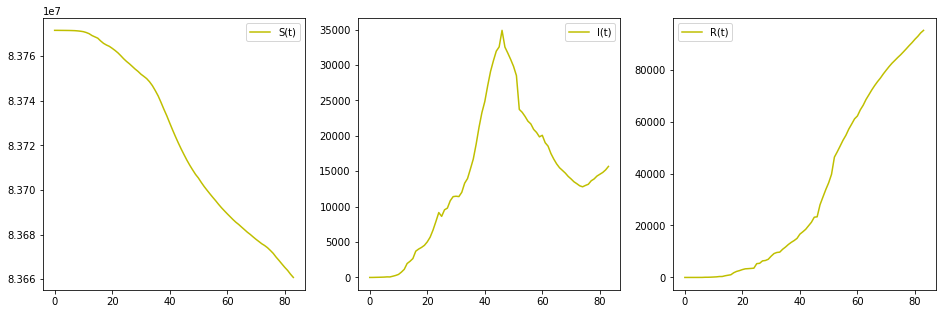

In [449]:
sus,inf,rem = master_data_norm_req.T.values
f = plt.figure(figsize=(16,5))
ax = f.add_subplot(1,3,1)
ax.plot(sus, 'y', label='S(t)')
plt.legend()

ax2 = f.add_subplot(1,3,2)
ax2.plot(inf, 'y', label='I(t)')
plt.legend()

ax2 = f.add_subplot(1,3,3)
ax2.plot(rem, 'y', label='R(t)')
plt.legend()

In [504]:
# Initial Conditions
i_0 = master_data_norm.confirmed.values[0]
r_0 = 0
s_0 = N - i_0 - r_0

y_0 = [s_0, i_0, r_0]

In [505]:
y_0

[83771585, 2, 0]

# SIR Model

In [296]:
# Model Definition
def sir_model(t, y, beta, v):
    s, i, r = y
    dsdt = -beta * s * i / N
    didt = beta * s * i / N - v * i
    drdt = v * i
    return dsdt, didt, drdt

# Fitting the Model to Data

In [309]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [312]:
mean_squared_error([100],[90])**0.5, mean_squared_log_error([100],[90])**0.5

(10.0, 0.10426101032440993)

In [369]:
def msle(x,y):
    return np.mean((np.log1p(x) - np.log1p(y))**2)

In [358]:
msle([100],[90])**0.5

0.10426101032440993

In [350]:
sol = integrate.solve_ivp(sir_model, [0,104], y_0, t_eval = np.arange(0,104), args = initial_guess[:-1])
s, i, r = sol.y
print((i < 0).any())

False


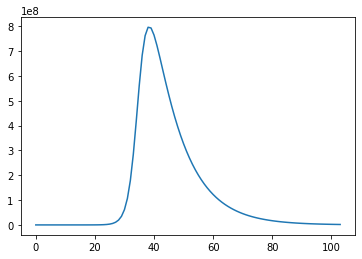

In [351]:
plt.plot(sol.t, i, label = 'I(t)')

In [507]:
# Curve Fitting Function - Minimize Mean Squared Log Error between Actual and Predicted
def msle_error_func(initial_guess, df, return_sol = False):
    days = len(df)
#     print(days)
    # Actual Data
    sus,inf,rem = df.T.values
#     print((inf < 0).any())
    
    # Predicting using SIR Model
    sol = integrate.solve_ivp(sir_model, [0,days], y_0, t_eval = np.arange(0,days), args = initial_guess)
    s, i, r = sol.y
#     print((i < 0).any())
#     for x in i:
#         print(x)
        
    
    # Calculating Error
#     msle_sus = mean_squared_log_error(sus,s)
#     msle_inf = mean_squared_log_error(inf,i)
#     msle_rem = mean_squared_log_error(rem,r)
    msle_sus = msle(sus,s)
    msle_inf = msle(inf,i)
    msle_rem = msle(rem,r)
    
    # Mean Error
    msle_mean = np.mean([msle_sus, msle_inf, msle_rem])
    
    if return_sol:
        return msle_mean, sol
    else:
        return msle_mean

In [508]:
msle_error_func((0.4,0.2),master_data_norm_req)

6.465247648015352

In [526]:
# Minimize the error
res = optimize.minimize(msle_error_func, 
                         initial_guess[:-1], 
                         args = (master_data_norm_req[13:17]), 
                         bounds=(
                             (0.2, 1.0), # Transmission Rate bounds
                             (0.1, 1.0) # transition time param bounds
                         )
                        )

In [527]:
res

      fun: 21.968143931152067
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.44118509e+00,  2.13162821e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 8
   status: 0
  success: True
        x: array([1.        , 0.23752502])

In [528]:
res.x[0] / res.x[1]

4.2100828208400465

In [512]:
res_1, sol = msle_error_func(res.x,master_data_norm_req, True)

In [513]:
ss, ii, rr = sol.y

In [514]:
ss, sus

(array([83771585.        , 83771582.83851023, 83771580.31853384,
        83771577.38141304, 83771573.95774311, 83771569.96611643,
        83771565.31248252, 83771559.88577048, 83771553.56418277,
        83771546.19941862, 83771537.61336939, 83771527.59811856,
        83771515.91594172, 83771502.29927129, 83771486.41893603,
        83771467.91779856, 83771446.38162793, 83771421.29504636,
        83771392.0415292 , 83771357.90340488, 83771318.06185505,
        83771271.59691444, 83771217.46445794, 83771154.32047394,
        83771080.81493765, 83770995.28034525, 83770895.64805205,
        83770779.44827254, 83770643.81008041, 83770485.4614085 ,
        83770300.72904883, 83770085.5364623 , 83769834.58127357,
        83769542.26195538, 83769202.22303227, 83768806.39821093,
        83768345.01038024, 83767806.57161127, 83767177.88315728,
        83766444.03545372, 83765588.4081182 , 83764592.00369234,
        83763429.79146898, 83762077.37205371, 83760504.30646485,
        83758672.6533797 

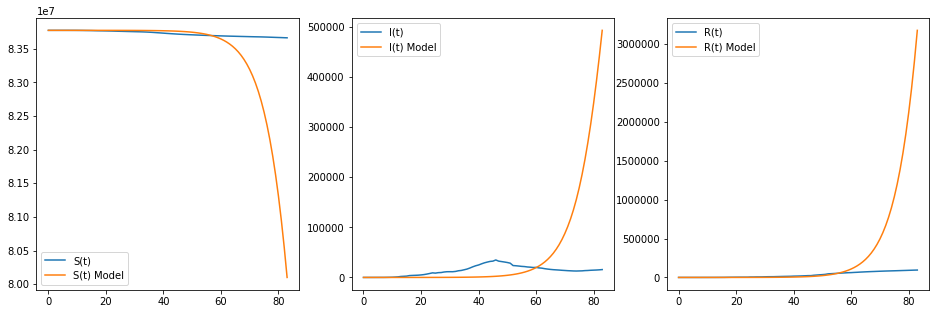

In [516]:
f = plt.figure(figsize=(16,5))
ax = f.add_subplot(1,3,1)
ax.plot(sus, 'y', color ='tab:blue', label='S(t)')
ax.plot(ss, 'y', color ='tab:orange', label='S(t) Model')
ax.ticklabel_format(useOffset=False)
plt.legend()

ax2 = f.add_subplot(1,3,2)
ax2.plot(inf, 'y', color ='tab:blue', label='I(t)')
ax2.plot(ii, 'y', color ='tab:orange', label='I(t) Model')
plt.legend()

ax2 = f.add_subplot(1,3,3)
ax2.plot(rem, 'y', color ='tab:blue', label='R(t)')
ax2.plot(rr, 'y', color ='tab:orange', label='R(t) Model')
plt.legend()

# Example Model 1

In [132]:
t = np.linspace(0,150,151)   # 5 months timeline

Text(0, 0.5, 'Fraction of Population')

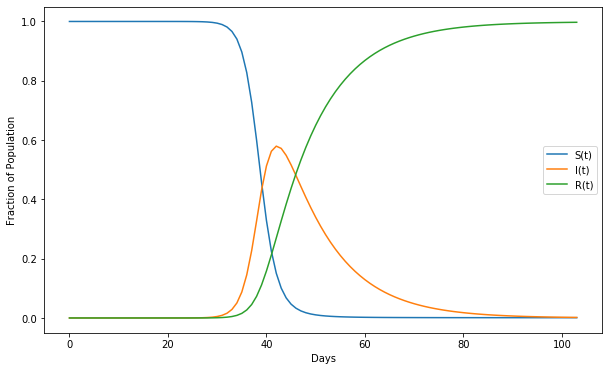

In [280]:
# Solves Initial Value Problem using Runge-Kutta Numerical Method
# Disease Transmission Rate, beta = 0.7 and 
# Removal Rate, v = 0.1
# sol = integrate.solve_ivp(sir_model, [0,150], y_0, t_eval = t, args = (0.7,0.1))  

plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[0], label = 'S(t)')
plt.plot(sol.t, sol.y[1], label = 'I(t)')
plt.plot(sol.t, sol.y[2], label = 'R(t)')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Fraction of Population')

# Example Model 2

Text(0.5, 1.0, 'Delaying the Curve')

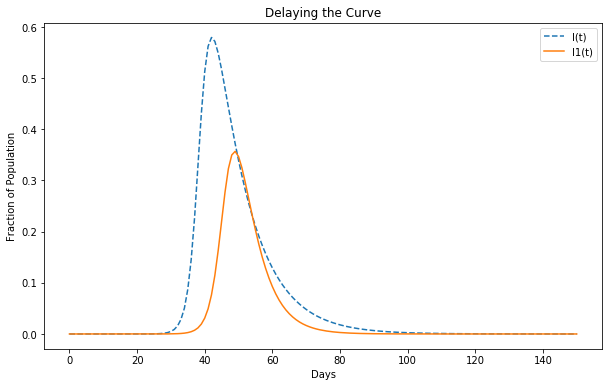

In [153]:
sol1 = integrate.solve_ivp(sir_model, [0,150], y_0, t_eval = t, args = (0.7,0.2))     # beta = 0.7 and v = 0.2

plt.figure(figsize=(10,6))
# plt.plot(sol.t, sol.y[0], label = 'S(t)')
plt.plot(sol.t, sol.y[1], label = 'I(t)',linestyle = 'dashed')
plt.plot(sol.t, sol1.y[1], label = 'I1(t)')
# plt.plot(sol.t, sol.y[2], label = 'R(t)')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Fraction of Population')
plt.title("Delaying the Curve")

# Example 

In [223]:
def model(t,y,a,b):
    dydt = 2*a*t + b
#     dydt = t
    return dydt

In [219]:
y0 = 0.5

In [220]:
t = np.linspace(-1,1,21)

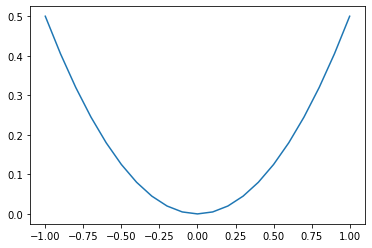

In [216]:
# sol = integrate.odeint(model, y0, t)
# plt.plot(t, sol)
# plt.show()

In [217]:
from scipy import optimize

In [244]:
def func(u):
    x, y = u
    return x**2 + y**2

In [245]:
optimize.minimize(func, (1,1))

      fun: 2.311471135620994e-16
 hess_inv: array([[ 0.75, -0.25],
       [-0.25,  0.75]])
      jac: array([-6.59986732e-09, -6.59986732e-09])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([-1.07505143e-08, -1.07505143e-08])

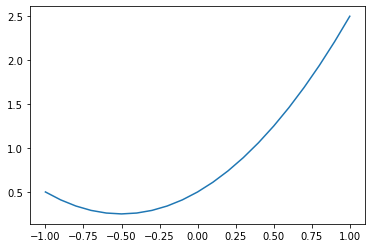

In [224]:
sol = integrate.solve_ivp(model, [-1,1], [0.5], t_eval = t, args = (1,1))
plt.plot(sol.t, sol.y[0])
plt.show()

In [ ]:
optimize.minimize()

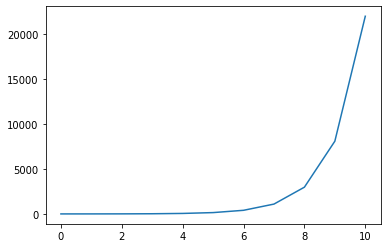

In [63]:
plt.plot(t,np.exp(t))

In [40]:
from scipy import optimize

In [41]:
def f(x,a,b,c):
    return a*x**2 + b*x + c

In [49]:
optimize.minimize(f, x0 = 0, args = (1,0,1))

      fun: array([1.])
 hess_inv: array([[1]])
      jac: array([1.49011612e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.])